<a href="https://colab.research.google.com/github/rfablet/DinAE/blob/master/notebookPyTorch_DinAE_L63.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import tensorflow.keras as keras

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition

In [2]:
!pip install torchviz
import torchviz

In [3]:
#!mkdir /content/PythonCode
#os.mkdir('/content/PythonCode')
#os.chdir('/content/PythonCode/')
#!git clone https://github.com/CIA-Oceanix/DinAE.git
os.chdir('/content/PythonCode/DinAE')
!git pull
#import DinAE

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/CIA-Oceanix/DinAE
   5f13945..a7951d0  master     -> origin/master
Updating 5f13945..a7951d0
Fast-forward
 dinAE_solver_torch.py | 20 ++++++++++++++++++++
 1 file changed, 20 insertions(+)


In [0]:
#os.mkdir('/content/PythonCode')
#os.chdir('/content/PythonCode')
#!git clone https://github.com/CIA-Oceanix/DinAE.git
os.chdir('/content/PythonCode/DinAE')
import dinAE_solver_torch as dinAE

In [5]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/My\ Drive/ResearchData/patchDataset_OcciputData.nc
import os
os.chdir('/content/drive/My Drive/')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/drive/My Drive/ResearchData/patchDataset_OcciputData.nc'
/content/drive/My Drive


# L63 Data simulation

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/AnDA')
from AnDA_codes.AnDA_generate_data import AnDA_generate_data

(10000, 3)


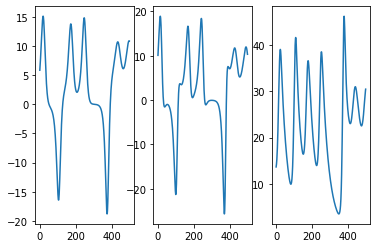

In [7]:
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from AnDA_codes.AnDA_dynamical_models import AnDA_Lorenz_63, AnDA_Lorenz_96

class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8 # number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1,2]) # indices of the observed variables
    nb_loop_train = 10**2 # size of the catalog
    nb_loop_test = 10000 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation

GD = GD()    
y0 = np.array([8.0,0.0,30.0])
tt = np.arange(GD.dt_integration,GD.nb_loop_test*GD.dt_integration+0.000001,GD.dt_integration)
#S = odeint(AnDA_Lorenz_63,x0,np.arange(0,5+0.000001,GD.dt_integration),args=(GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta));
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[0.,5+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=np.arange(0,5+0.000001,GD.dt_integration),method='RK45')

y0 = S.y[:,-1];
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta),t_span=[0.01,GD.nb_loop_test+0.000001],y0=y0,first_step=GD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()

print(S.shape)
plt.figure(1)
for jj in range(0,3):
  plt.subplot(131+jj)
  plt.plot(S[0:500,jj])
  
class time_series:
  values = 0.
  time   = 0.
  
xt = time_series()
xt.values = S
xt.time   = tt

# L63 Patch data extraction

In [0]:
from sklearn.feature_extraction import image

time_step = 2

# extract subsequences
dT = 200
dataTrainingNoNaN = image.extract_patches_2d(xt.values[0:7000:time_step,:],(dT,3),50000)
dataTestNoNaN     = image.extract_patches_2d(xt.values[7000::time_step,:],(dT,3),10000)

# create missing data
rateMissingData = 0.75
indRand         = np.random.permutation(dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2])
indRand         = indRand[0:int(rateMissingData*len(indRand))]
dataTraining    = np.copy(dataTrainingNoNaN).reshape((dataTrainingNoNaN.shape[0]*dataTrainingNoNaN.shape[1]*dataTrainingNoNaN.shape[2],1))
dataTraining[indRand] = float('nan')
dataTraining    = np.reshape(dataTraining,(dataTrainingNoNaN.shape[0],dataTrainingNoNaN.shape[1],dataTrainingNoNaN.shape[2]))

indRand         = np.random.permutation(dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2])
indRand         = indRand[0:int(rateMissingData*len(indRand))]
dataTest        = np.copy(dataTestNoNaN).reshape((dataTestNoNaN.shape[0]*dataTestNoNaN.shape[1]*dataTestNoNaN.shape[2],1))
dataTest[indRand] = float('nan')
dataTest          = np.reshape(dataTest,(dataTestNoNaN.shape[0],dataTestNoNaN.shape[1],dataTestNoNaN.shape[2]))

# data normalization
if 1*1:
  if 1*1:
    meanTr       = np.nanmean(dataTraining[:]) 
    dataTraining = dataTraining - meanTr
    dataTest     = dataTest - meanTr

    # scale wrt std
    stdTr        = np.sqrt( np.nanmean( dataTraining**2 ) )
    dataTraining = dataTraining / stdTr
    dataTest     = dataTest / stdTr

    dataTrainingNoNaN = (dataTrainingNoNaN - meanTr ) / stdTr
    dataTestNoNaN     = (dataTestNoNaN - meanTr ) / stdTr
  else:
    mini = np.amin(dataTraining[:])
    maxi = np.amax(dataTraining[:])

    dataTraining = (dataTraining - mini ) /(maxi-mini)
    dataTest     = (dataTest - mini ) /(maxi-mini)

    dataTrainingNoNaN = (dataTrainingNoNaN - mini ) /(maxi-mini)
    dataTestNoNaN     = (dataTestNoNaN - mini ) /(maxi-mini)

# set to NaN patch boundaries
dataTraining[:,0:10,:] =  float('nan')
dataTest[:,0:10,:]     =  float('nan')
dataTraining[:,dT-10:dT,:] =  float('nan')
dataTest[:,dT-10:dT,:]     =  float('nan')

# mask for NaN
maskTraining = (dataTraining == dataTraining).astype('float')
maskTest     = ( dataTest    ==  dataTest   ).astype('float')

dataTraining = np.nan_to_num(dataTraining)
dataTest     = np.nan_to_num(dataTest)

# set to NaN patch boundaries
#dataTraining[:,0:5,:] =  dataTrainingNoNaN[:,0:5,:]
#dataTest[:,0:5,:]     =  dataTestNoNaN[:,0:5,:]

In [0]:
x_train         = np.moveaxis( dataTrainingNoNaN.reshape((dataTrainingNoNaN.shape[0],dataTrainingNoNaN.shape[1],dataTrainingNoNaN.shape[2])) , 2 , 1 )
x_train_missing = np.moveaxis( dataTraining.reshape((dataTraining.shape[0],dataTraining.shape[1],dataTraining.shape[2])) , 2 , 1 )
mask_train      = np.moveaxis( maskTraining.reshape((maskTraining.shape[0],maskTraining.shape[1],maskTraining.shape[2])) , 2 , 1 )

x_test         = np.moveaxis( dataTestNoNaN.reshape((dataTestNoNaN.shape[0],dataTestNoNaN.shape[1],dataTestNoNaN.shape[2])) , 2 , 1 )
x_test_missing = np.moveaxis( dataTest.reshape((dataTest.shape[0],dataTest.shape[1],dataTest.shape[2])) , 2 , 1 )
mask_test      = np.moveaxis( maskTest.reshape((maskTest.shape[0],maskTest.shape[1],maskTest.shape[2])) , 2 , 1 )

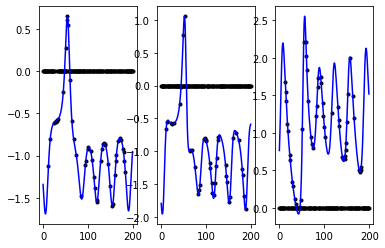

In [10]:
idx = 180

# Visualisation
plt.figure(1)
for jj in range(0,3):
  indjj = 131+jj
  plt.subplot(indjj)
  plt.plot(x_train_missing[idx,jj,:],'k.')
  plt.plot(x_train[idx,jj,:],'b-')

# PCA Decomposition & AE architecture

In [0]:
DimAE      = 20#50

In [12]:
# PCA decomposition
pca              = decomposition.PCA(DimAE)
pca.fit(np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2])))

rec_PCA_Tt       = pca.transform(np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2])))
rec_PCA_Tt[:,DimAE:] = 0.
rec_PCA_Tt       = pca.inverse_transform(rec_PCA_Tt)
mse_PCA_Tt       = np.mean( (rec_PCA_Tt - x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2])))**2 )
var_Tt           = np.mean( (x_test-np.mean(x_train,axis=0))** 2 )
exp_var_PCA_Tt   = 1. - mse_PCA_Tt / var_Tt

print(".......... PCA Dim = %d"%(DimAE))
print('.... explained variance PCA (Tr) : %.2f%%'%(100.*np.cumsum(pca.explained_variance_ratio_)[DimAE-1]))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*exp_var_PCA_Tt))

# visualize PCs and associated projection
PC              = np.zeros((DimAE+1,x_test.shape[1]*x_test.shape[2])) * float('NaN')                        
PC[1:DimAE+1,:] = pca.components_
PC[0,:]         = pca.mean_
PC              = np.reshape(PC,(DimAE+1,x_test.shape[1],x_test.shape[2]))

.......... PCA Dim = 20
.... explained variance PCA (Tr) : 84.14%
.... explained variance PCA (Tt) : 82.23%


In [0]:
class ConstrainedConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=1,
                 bias=True):
        super(ConstrainedConv1d,
              self).__init__(in_channels, out_channels, kernel_size, stride,
                             padding, dilation, groups, bias)
        with torch.no_grad():
          self.weight[:,:,int(self.weight.size(2)/2)+1] = 0.0
    def forward(self, input):
        return torch.nn.functional.conv1d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


In [13]:
flagAEType = 2
DimAE      = 10#50
dropout    = 0.05
wl2        = 0
shapeData = x_train.shape[1:]

if flagAEType == 0: ## MLP-AE

  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.fc1 = torch.nn.Linear(shapeData[0]*shapeData[1],6*DimAE)
          self.fc2 = torch.nn.Linear(6*DimAE,2*DimAE)
          self.fc3 = torch.nn.Linear(2*DimAE,DimAE)

      def forward(self, x):
          #x = self.fc1( torch.nn.Flatten(x) )
          x = self.fc1( x.view(-1,shapeData[0]*shapeData[1]) )
          x = self.fc2( F.relu(x) )
          x = self.fc3( F.relu(x) )
          return x

  encoder = Encoder()

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()
          self.fc1 = torch.nn.Linear(DimAE,10*DimAE)
          self.fc2 = torch.nn.Linear(10*DimAE,20*DimAE)
          self.fc3 = torch.nn.Linear(20*DimAE,shapeData[0]*shapeData[1])

      def forward(self, x):
          x = self.fc1( x )
          x = self.fc2( F.relu(x) )
          x = self.fc3( F.relu(x) )
          x = x.view(-1,shapeData[0],shapeData[1])
          return x

elif flagAEType == 1: ## Conv-AE
  Wpool_i = np.floor(  (np.floor((x_train.shape[2]-2)/2)-2)/2 ).astype(int) 

  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.conv1 = torch.nn.Conv1d(shapeData[0],DimAE,3,padding=0)
          self.pool1 = torch.nn.AvgPool1d(2)
          self.conv2 = torch.nn.Conv2d(DimAE,2*DimAE,3,padding=0)
          self.pool2 = torch.nn.AvgPool1d(2)
          self.conv3 = torch.nn.Conv2d(2*DimAE,4*DimAE,Wpool_i,padding=0)
          self.conv4 = torch.nn.Conv2d(4*DimAE,DimAE,(1,1),padding=0)

      def forward(self, x):
          #x = self.fc1( torch.nn.Flatten(x) )
          x = self.conv1( x )
          x = self.pool1(x)
          x = self.conv2( F.relu(x) )
          x = self.pool2(x)
          x = self.conv3( F.relu(x) )
          x = self.conv4( F.relu(x) )
          x = x.view(-1,DimAE)
          return x

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()
          #self.conv1Tr = torch.nn.ConvTranspose2d(DimAE,1,(x_train.shape[1],x_train.shape[2]),stride=(x_train.shape[1],x_train.shape[2]),bias=False)
          self.conv1Tr = torch.nn.ConvTranspose1d(DimAE,DimAE,int(x_train.shape[2]/2),stride=int(x_train.shape[2]/2),bias=False)
          self.conv11   = torch.nn.Conv1d(DimAE,DimAE,3,padding=1)
          self.conv12   = torch.nn.Conv1d(DimAE,DimAE,3,padding=1)
          self.conv2Tr = torch.nn.ConvTranspose1d(DimAE,DimAE,2,stride=2,bias=False)
          #self.resnet  = self._make_ResNet(2,DimAE,5,3,1)
          self.resnet = dinAE.ResNetConv1D(2,DimAE,5,3,1)
          self.convF   = torch.nn.Conv1d(DimAE,1,(1,1),padding=0)
      def _make_ResNet(self,Nblocks,dim,K,kernel_size, padding):
          layers = []
          for kk in range(0,Nblocks):
            layers.append(torch.nn.Conv2d(dim,K*dim,kernel_size,padding=padding,bias=False))
            layers.append(torch.nn.Conv2d(K*dim,dim,kernel_size,padding=padding,bias=False))

          return torch.nn.Sequential(*layers)

      def forward(self, x):
          x = x.view(-1,DimAE,1,1)
          x = self.conv1Tr( x )
          x = torch.add(self.conv12( F.relu( self.conv11(x) ) ),x)
          x = torch.add(self.conv12( F.relu( self.conv11(x) ) ),x)
          x = self.conv2Tr( x )
          x = self.resnet(x)
          x = self.convF(x)

          #x = torch.add(self.conv22( F.relu( self.conv21(x) ) ),x)
          #x = torch.add(self.conv22( F.relu( self.conv21(x) ) ),x)
          #x = self.conv3( x )
          #x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x

elif flagAEType == 2: ## Conv model with no use of the central point
  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1 = torch.nn.AvgPool1d(2)
          self.conv1 = dinAE.ConstrainedConv1d(shapeData[0],shapeData[0]*DimAE,7,padding=3)
          self.conv2 = torch.nn.Conv1d(shapeData[0]*DimAE,2*shapeData[0]*DimAE,1,padding=0)
          self.conv3 = torch.nn.Conv1d(2*shapeData[0]*DimAE,4*shapeData[0]*DimAE,1,padding=0)
          self.conv4 = torch.nn.Conv1d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,1,padding=0)

          self.conv2Tr = torch.nn.ConvTranspose1d(8*shapeData[0]*DimAE,8*shapeData[0]*DimAE,2,stride=2,bias=False)          
          self.conv5 = torch.nn.Conv1d(8*shapeData[0]*DimAE,16*shapeData[0]*DimAE,3,padding=1)
          self.conv6 = torch.nn.Conv1d(16*shapeData[0]*DimAE,shapeData[0],3,padding=1)

      def forward(self, x):
          #x = self.fc1( torch.nn.Flatten(x) )
          x = self.pool1( x )
          x = self.conv1(x)
          x = self.conv2( F.relu(x) )
          x = self.conv3( F.relu(x) )
          x = self.conv4( F.relu(x) )
          x = self.conv2Tr( x )
          x = self.conv5( x )
          x = self.conv6( x )
          x = x.view(-1,shapeData[0],shapeData[1])
          return x

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)

class Model_AE(torch.nn.Module):
    def __init__(self):
        super(Model_AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder( x )
        x = self.decoder( x )
        return x

model_AE = Model_AE()

print(model_AE)
print('Number of trainable parameters = %d'%(sum(p.numel() for p in model_AE.parameters() if p.requires_grad)))

Model_AE(
  (encoder): Encoder(
    (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (conv1): ConstrainedConv1d(3, 30, kernel_size=(7,), stride=(1,), padding=(3,))
    (conv2): Conv1d(30, 60, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(60, 120, kernel_size=(1,), stride=(1,))
    (conv4): Conv1d(120, 240, kernel_size=(1,), stride=(1,))
    (conv2Tr): ConvTranspose1d(240, 240, kernel_size=(2,), stride=(2,), bias=False)
    (conv5): Conv1d(240, 480, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv6): Conv1d(480, 3, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (decoder): Decoder()
)
Number of trainable parameters = 504483


torch.Size([21, 3, 200])


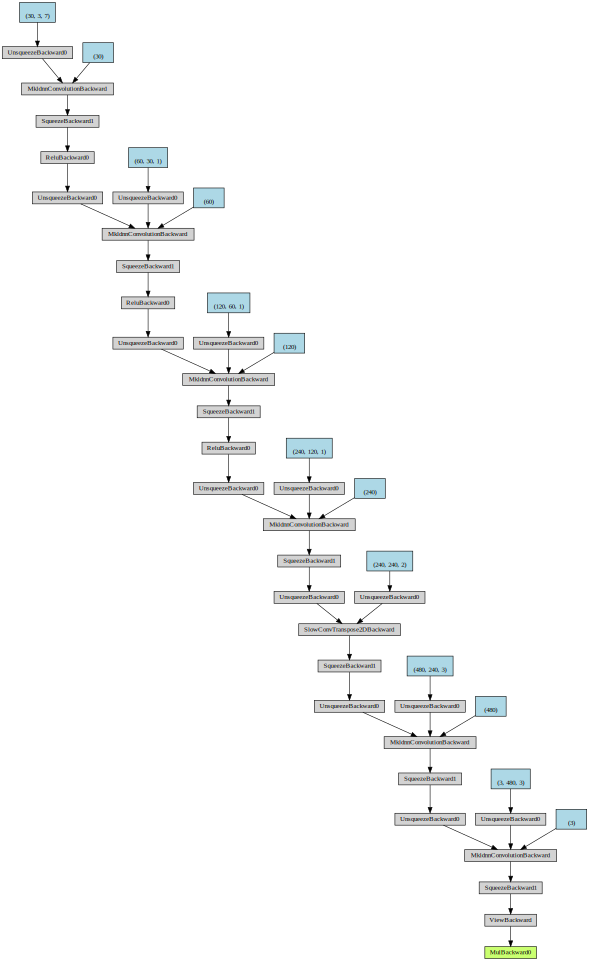

In [14]:
#Model visualisation
inputs = torch.randn(21,3,200)
y = model_AE(torch.autograd.Variable(inputs))
print(y.size())
torchviz.make_dot(y)

# Learning AE model

In [0]:
# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
}

dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

In [0]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model_AE  = model_AE.to(device)
#model_AE.resnet = model_AE.decoder.resnet.to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer        = optim.Adam(model_AE.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# mean-squared error loss
criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )

# training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_var  = 0.0

            # Iterate over data.
            for inputs_ in dataloaders[phase]:
                inputs = inputs_[0]
                inputs = inputs.to(device)
                #print(inputs.size(0))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #loss = criterion(outputs, inputs)
                    loss = torch.mean((outputs - inputs)**2)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss   += loss.item() * inputs.size(0)
                #running_expvar += torch.sum( (outputs - inputs)**2 ) / torch.sum(
            if phase == 'train':
                scheduler.step()

            epoch_loss  = running_loss / dataset_sizes[phase]
            if phase == 'train':
              epoch_nloss = epoch_loss / var_Tr
            else:
              epoch_nloss = epoch_loss / var_Tt
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} NLoss: {:.4f} '.format(
                phase, epoch_loss, epoch_nloss))
#            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
# training AE model
model_AE = train_model(model_AE, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0844 NLoss: 0.0845 
val Loss: 0.0043 NLoss: 0.0043 

Epoch 1/4
----------
train Loss: 0.0022 NLoss: 0.0022 
val Loss: 0.0011 NLoss: 0.0011 

Epoch 2/4
----------


KeyboardInterrupt: ignored

# Learning AE model from irregularly-sampled data (DinAE model)

In [0]:
class Model_AE_GradFP(torch.nn.Module):
    def __init__(self,mod_AE,ShapeData,NiterProjection,NiterGrad,GradType,OptimType):
    #def __init__(self,mod_AE,GradType,OptimType):
        super(Model_AE_GradFP, self).__init__()
        self.model_AE = mod_AE

        with torch.no_grad():
            self.GradType = GradType
            self.OptimType = OptimType
            self.NProjFP   = int(NiterProjection)
            self.NGrad     = int(NiterGrad)
            self.shape     = ShapeData
        
        if len(self.shape) == 2: ## 1D Data
            if self.OptimType == 0: # fixed-step gradient descent
              self.conv1    = torch.nn.Conv1d(self.shape[0], self.shape[0],1, padding=0)              
            elif self.OptimType == 1: # ConvNet gradient descent using previous and current gradient
              self.conv1    = torch.nn.Conv1d(2*self.shape[0], 8*self.shape[0],3, padding=1)
              self.conv2    = torch.nn.Conv1d(8*self.shape[0], 16*self.shape[0],3, padding=1)
              self.conv3    = torch.nn.Conv1d(16*self.shape[0], self.shape[0],3, padding=1)
            elif self.OptimType == 2: # ConvNet gradient descent using previous and current gradient
              self.lstm1    = ConvLSTM1d(self.shape[0],5*self.shape[0],3)
              self.conv1    = torch.nn.Conv1d(5*self.shape[0], self.shape[0], 1, padding=0)           
        elif len(self.shape) == 3: ## 2D Data            
            if self.OptimType == 0: # fixed-step gradient descent
              self.conv1    = torch.nn.Conv2d(self.shape[0], self.shape[0], (1,1), padding=0)
            elif self.OptimType == 1: # ConvNet gradient descent using previous and current gradient
              self.conv1    = torch.nn.Conv2d(2*self.shape[0], 8*self.shape[0], (3,3), padding=1)
              self.conv2    = torch.nn.Conv2d(8*self.shape[0], 16*self.shape[0], (3,3), padding=1)
              self.conv3    = torch.nn.Conv2d(16*self.shape[0], self.shape[0], (3,3), padding=1)
            elif self.OptimType == 2: # ConvNet gradient descent using previous and current gradient
              self.lstm1    = ConvLSTM2d(self.shape[0],5*self.shape[0],3)
              self.conv1    = torch.nn.Conv2d(5*self.shape[0], self.shape[0], (1,1), padding=0)
    def forward(self, x_inp,mask):
        #mask   = torch.add(1.0,torch.mul(mask,0.0)) # set mask to 1 # debug
        mask_  = torch.add(1.0,torch.mul(mask,-1.0)) #1. - mask
        x      = torch.mul(x_inp,1.0)

        # fixed-point iterations
        if self.NProjFP > 0:
          for kk in range(0,self.NProjFP):
        #if NiterProjection > 0:
        #  x      = torch.mul(x_inp,1.0)
        #  for kk in range(0,NiterProjection):            
            x_proj = self.model_AE(x)
            x_proj = torch.mul(x_proj,mask_)
            x      = torch.mul(x, mask)   
            x      = torch.add(x , x_proj )

        # gradient iteration
        if self.NGrad > 0:
          for kk in range(0,self.NGrad):
        #if NiterGrad > 0:
        #  for kk in range(0,NiterGrad):
            # compute gradient
            if self.GradType == 0: ## subgradient
              grad = torch.add(self.model_AE(x),-1.,x)
            else: ## true gradient using autograd
              loss = torch.sum( torch.add(self.model_AE(x),-1.,x)**2 )
              grad = torch.autograd.grad(loss,x)[0]
            #grad = grad.view(-1,1,self.shape[1],self.shape[2])
            grad.retain_grad()

            # gradient step

            if self.OptimType == 0: # fixed-step gradient
              grad = self.conv1( grad )
            elif self.OptimType == 1: # convNet for grad using previous and current gradient
              if kk == 0:
                grad_old = torch.randn(grad.size()).to(device)
              gradAll  = torch.cat((grad_old,grad),1)
              grad_old = torch.mul(1.,grad)

              grad = self.conv1( gradAll )
              grad = self.conv2( F.relu( grad ) )
              grad = self.conv3( F.relu( grad ) )
              #grad = grad.view(-1,self.shape[1],self.shape[2])

            elif self.OptimType == 2: # convLSTLM suing grad as input
              if kk == 0:
                hidden,cell = self.lstm1(grad,None)
              else:
                hidden,cell = self.lstm1(grad,[hidden,cell])
              grad = self.conv1(hidden)

            # update
            #grad  = grad.view(-1,self.shape[1],self.shape[2])
            x_new = torch.add(x,grad)
            x_new = torch.mul(x_new,mask_)
            x     = torch.mul(x, mask)   
            x     = torch.add(x , x_new )

        x_proj        = self.model_AE(x)
        return x_proj



In [0]:
# training function for dinAE
def train_model(model, optimizer, scheduler,alpha, num_epochs=25):
    since = time.time()

    alpha_MaskedLoss = alpha[0]
    alpha_GTLoss     = 1. - alpha[0]
    alpha_AE         = alpha[1]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #rint('Learning')
                model.train()  # Set model to training mode
            else:
                #print('Evaluation')
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_loss_All     = 0.
            running_loss_R       = 0.
            running_loss_I       = 0.
            running_loss_AE      = 0.
            num_loss     = 0

            # Iterate over data.
            #for inputs_ in dataloaders[phase]:
            #    inputs = inputs_[0].to(device)
            for inputs_missing,masks,inputs_GT in dataloaders[phase]:
                inputs_missing = inputs_missing.to(device)
                masks          = masks.to(device)
                inputs_GT      = inputs_GT.to(device)
                #print(inputs.size(0))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # need to evaluate grad/backward during the evaluation and training phase for model_AE
                with torch.set_grad_enabled(True): 
                #with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs_missing,masks)
                    #outputs = model(inputs)
                    #loss = criterion( outputs,  inputs)
                    loss_R      = torch.sum((outputs - inputs_GT)**2 * masks )
                    loss_R      = torch.mul(1.0 / torch.sum(masks),loss_R)
                    loss_I      = torch.sum((outputs - inputs_GT)**2 * (1. - masks) )
                    loss_I      = torch.mul(1.0 / torch.sum(1.-masks),loss_I)
                    loss_All    = torch.mean((outputs - inputs_GT)**2 )
                    loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )
                    loss_AE_GT  = torch.mean((model.model_AE(inputs_GT) - inputs_GT)**2 )
                    
                    if alpha_MaskedLoss > 0.:
                        loss = torch.mul(alpha_MaskedLoss,loss_R)
                    else: 
                        loss = torch.mul(alpha_GTLoss,loss_All)
                    loss = torch.add(loss,torch.mul(alpha_AE,loss_AE))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss             += loss.item() * inputs_missing.size(0)
                running_loss_I           += loss_I.item() * inputs_missing.size(0)
                running_loss_R           += loss_R.item() * inputs_missing.size(0)
                running_loss_All         += loss_All.item() * inputs_missing.size(0)
                running_loss_AE          += loss_AE_GT.item() * inputs_missing.size(0)
                num_loss                 += inputs_missing.size(0)
                #running_expvar += torch.sum( (outputs - inputs)**2 ) / torch.sum(
            if phase == 'train':
                scheduler.step()

            epoch_loss       = running_loss / num_loss
            epoch_loss_All   = running_loss_All / num_loss
            epoch_loss_AE    = running_loss_AE / num_loss
            epoch_loss_I     = running_loss_I / num_loss
            epoch_loss_R     = running_loss_R / num_loss
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
              epoch_nloss_All = epoch_loss_All / var_Tr
              epoch_nloss_I   = epoch_loss_I / var_Tr
              epoch_nloss_R   = epoch_loss_R / var_Tr
              epoch_nloss_AE  = loss_AE / var_Tr
            else:
              epoch_nloss_All = epoch_loss_All / var_Tt
              epoch_nloss_I   = epoch_loss_I / var_Tt
              epoch_nloss_R   = epoch_loss_R / var_Tt
              epoch_nloss_AE   = loss_AE / var_Tt

            #print('{} Loss: {:.4f} '.format(
             #   phase, epoch_loss))
            print('{} Loss: {:.4f} NLossAll: {:.4f} NLossR: {:.4f} NLossI: {:.4f} NLossAE: {:.4f}'.format(
                phase, epoch_loss,epoch_nloss_All,epoch_nloss_R,epoch_nloss_I,epoch_nloss_AE))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [0]:
# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)

# no mask
#training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train),torch.add(1.0,torch.mul(0.0,torch.Tensor(mask_train))),torch.Tensor(x_train)) # create your datset
#test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test),torch.add(1.0,torch.mul(0.0,torch.Tensor(mask_test))),torch.Tensor(x_test)) # create your datset

training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_missing),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_missing),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
}

dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

In [0]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )

if 1*1:
  model_AE2    = Model_AE()

if 1*1:
    alpha           = np.array([1.0,0.1])
    GradType        = 1 # Gradient computation (0: subgradient, 1: true gradient/autograd)
    OptimType       = 1 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent
    NiterProjection = 5 # Number of fixed-point iterations
    NiterGrad       = 2 # Number of gradient descent step
    
    # NiterProjection,NiterGrad: global variables
    # bug for NiterProjection = 0
    shapeData       = x_train.shape[1:]
    #model_AE_GradFP = Model_AE_GradFP(model_AE2,shapeData,NiterProjection,NiterGrad,GradType,OptimType)
    model_AE_GradFP = dinAE.Model_AE_GradFP(model_AE2,shapeData,NiterProjection,NiterGrad,GradType,OptimType)

    model_AE_GradFP = model_AE_GradFP.to(device)

    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer        = optim.Adam(model_AE_GradFP.parameters(), lr=1e-4)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [21]:
# model training
model_AE_GradFP = train_model(model_AE_GradFP, optimizer, exp_lr_scheduler,
                       alpha,num_epochs=100)

Epoch 0/99
----------
train Loss: 0.0043 NLossAll: 0.0287 NLossR: 0.0041 NLossI: 0.0358 NLossAE: 0.0015
val Loss: 0.0036 NLossAll: 0.0265 NLossR: 0.0034 NLossI: 0.0332 NLossAE: 0.0012

Epoch 1/99
----------
train Loss: 0.0033 NLossAll: 0.0259 NLossR: 0.0031 NLossI: 0.0325 NLossAE: 0.0012
val Loss: 0.0029 NLossAll: 0.0244 NLossR: 0.0028 NLossI: 0.0307 NLossAE: 0.0010

Epoch 2/99
----------
train Loss: 0.0026 NLossAll: 0.0237 NLossR: 0.0025 NLossI: 0.0299 NLossAE: 0.0013
val Loss: 0.0024 NLossAll: 0.0225 NLossR: 0.0023 NLossI: 0.0284 NLossAE: 0.0011

Epoch 3/99
----------
train Loss: 0.0022 NLossAll: 0.0220 NLossR: 0.0021 NLossI: 0.0278 NLossAE: 0.0010
val Loss: 0.0021 NLossAll: 0.0206 NLossR: 0.0020 NLossI: 0.0260 NLossAE: 0.0009

Epoch 4/99
----------
train Loss: 0.0020 NLossAll: 0.0209 NLossR: 0.0019 NLossI: 0.0264 NLossAE: 0.0008
val Loss: 0.0019 NLossAll: 0.0198 NLossR: 0.0018 NLossI: 0.0250 NLossAE: 0.0010

Epoch 5/99
----------
train Loss: 0.0019 NLossAll: 0.0202 NLossR: 0.0018 NL